# FLUX.2 Klein Workshop: From API to LoRA Customization

**Black Forest Labs x NVIDIA**

This notebook demonstrates FLUX.2 Klein capabilities and shows how LoRA fine-tuning enables customization beyond what the base model can do.

## What We'll Cover

1. **API Quickstart** — Text-to-image generation with Klein 9B
2. **Exploring Limitations** — Prompts the model struggles with
3. **LoRA Training** — Fine-tuning Klein for custom concepts
4. **Results** — What becomes possible with customization

---

## Prerequisites

- **For API demos**: BFL API key from [dashboard.bfl.ai](https://dashboard.bfl.ai)
- **For LoRA training**: NVIDIA GPU with 24GB+ VRAM (A10G, RTX 4090, A100, etc.)

---

## Setup

In [2]:
# Install dependencies (uncomment if needed)
# !pip install requests matplotlib pillow torch diffusers transformers accelerate peft bitsandbytes

import os
import time
import base64
from io import BytesIO
from pathlib import Path
from typing import Optional, List

import requests
from PIL import Image
import matplotlib.pyplot as plt

# Display settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.grid'] = False

print("Setup complete!")

Setup complete!


In [3]:
# Configuration
BFL_API_KEY = os.environ.get("BFL_API_KEY", "1bb671bb-c0a3-4656-897b-3ce530cc0f0b")

API_BASE = "https://api.bfl.ai/v1"

OUTPUT_DIR = Path("./outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

def get_headers():
    """Get headers for BFL API requests."""
    return {
        "accept": "application/json",
        "x-key": BFL_API_KEY,
        "Content-Type": "application/json",
    }

---

# Part 1: FLUX.2 Klein 9B via API

Klein 9B is our best Klein model — sub-second generation with excellent prompt following.

| Model | License | Speed | VRAM (local) |
|-------|---------|-------|--------------|
| **Klein 9B** | FLUX Non-Commercial | Sub-second | ~24GB |
| **Klein 4B** | Apache 2.0 | Sub-second | ~13GB |

## 1.1 Helper Functions

In [4]:
def submit_request(endpoint: str, payload: dict) -> dict:
    """Submit a request to the BFL API."""
    url = f"{API_BASE}/{endpoint}"
    response = requests.post(url, headers=get_headers(), json=payload)
    response.raise_for_status()
    return response.json()


def poll_result(polling_url: str, max_wait: int = 120) -> dict:
    """Poll for the result of an async request."""
    start = time.time()
    
    while time.time() - start < max_wait:
        response = requests.get(polling_url, headers={"accept": "application/json", "x-key": BFL_API_KEY})
        result = response.json()
        
        status = result.get("status")
        if status == "Ready":
            return result["result"]
        elif status == "Failed":
            raise Exception(f"Generation failed: {result.get('error', 'Unknown error')}")
        
        time.sleep(0.5)
    
    raise TimeoutError(f"Request timed out after {max_wait}s")


def generate_image(endpoint: str, payload: dict, show: bool = True) -> Image.Image:
    """Generate an image and optionally display it."""
    print(f"Submitting request to {endpoint}...")
    response = submit_request(endpoint, payload)
    
    request_id = response["id"]
    polling_url = response["polling_url"]
    cost = response.get("cost", "N/A")
    
    print(f"Request ID: {request_id}")
    print(f"Cost: {cost} credits")
    print("Waiting for result...")
    
    result = poll_result(polling_url)
    
    image_url = result["sample"]
    image_response = requests.get(image_url)
    image = Image.open(BytesIO(image_response.content))
    
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        prompt_preview = payload.get('prompt', '')[:80]
        plt.title(f"{prompt_preview}...", fontsize=10, wrap=True)
        plt.tight_layout()
        plt.show()
    
    return image


def display_images_grid(images: List[Image.Image], titles: List[str] = None, cols: int = 3):
    """Display multiple images in a grid."""
    n = len(images)
    rows = (n + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten() if n > 1 else [axes]
    
    for idx, (ax, img) in enumerate(zip(axes, images)):
        ax.imshow(img)
        ax.axis('off')
        if titles and idx < len(titles):
            ax.set_title(titles[idx], fontsize=10)
    
    for ax in axes[n:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## 1.2 Text-to-Image with Klein 9B

Let's see what Klein 9B can do out of the box. Remember: **narrative prose, not keywords**.

Submitting request to flux-2-klein-9b-private...
Request ID: 09a9d036-78a6-4bd7-926d-0c8613666784
Cost: 0.0 credits
Waiting for result...


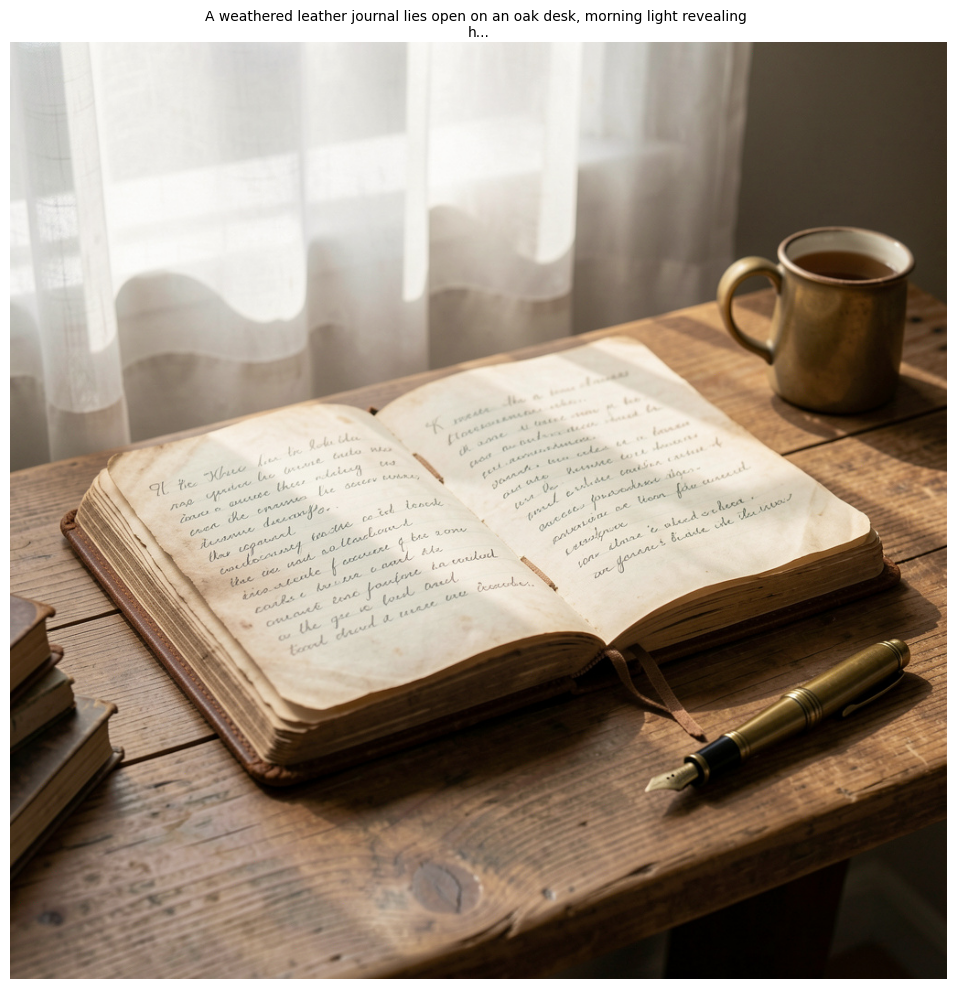

In [6]:
# A well-crafted narrative prompt
prompt = """
A weathered leather journal lies open on an oak desk, morning light revealing 
handwritten entries in faded ink. Soft, diffused natural light filters through 
sheer curtains, casting gentle shadows across the yellowed pages. A brass 
fountain pen rests beside the journal, its nib catching a glint of light.
""".strip()

payload = {
    "prompt": prompt,
    "width": 1024,
    "height": 1024,
    "seed": 42
}

image = generate_image("flux-2-klein-9b-private", payload)

Generating architectural shot...
Submitting request to flux-2-klein-9b-private...
Request ID: 9456f559-c9cc-4956-9284-36f4b1332107
Cost: 0.0 credits
Waiting for result...

Generating product shot...
Submitting request to flux-2-klein-9b-private...
Request ID: e64ac943-c5f5-45b9-83fe-a6100602f4f4
Cost: 0.0 credits
Waiting for result...


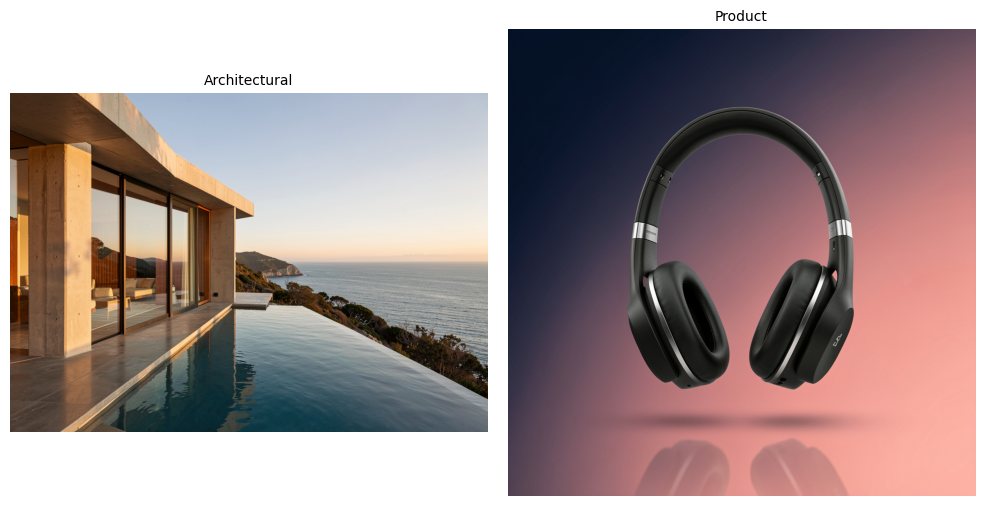

In [7]:
# More examples showcasing Klein 9B's strengths

# Architectural photography
arch_prompt = """
A modern minimalist house with floor-to-ceiling windows nestled into a 
hillside overlooking the ocean. The structure features clean concrete lines 
and warm wood accents. Golden hour sunlight casts long shadows across the 
infinity pool, which appears to merge with the horizon. Architectural 
photography style, wide angle lens.
""".strip()

# Product photography
product_prompt = """
A sleek wireless headphone in matte black with brushed aluminum accents, 
floating against a gradient background transitioning from deep navy to soft 
coral. Studio lighting creates subtle highlights on the ear cups with a 
gentle reflection beneath. Premium tech product photography style.
""".strip()

print("Generating architectural shot...")
arch_image = generate_image("flux-2-klein-9b-private", {"prompt": arch_prompt, "width": 1440, "height": 1024, "seed": 100}, show=False)

print("\nGenerating product shot...")
product_image = generate_image("flux-2-klein-9b-private", {"prompt": product_prompt, "width": 1024, "height": 1024, "seed": 200}, show=False)

display_images_grid([arch_image, product_image], ["Architectural", "Product"], cols=2)

## 1.3 Hex Color Matching

FLUX.2 supports precise color specification via hex codes — great for brand consistency.

Submitting request to flux-2-klein-9b-private...
Request ID: c12b83d7-9564-4c9e-a9a1-04c02e0b71c5
Cost: 0.0 credits
Waiting for result...


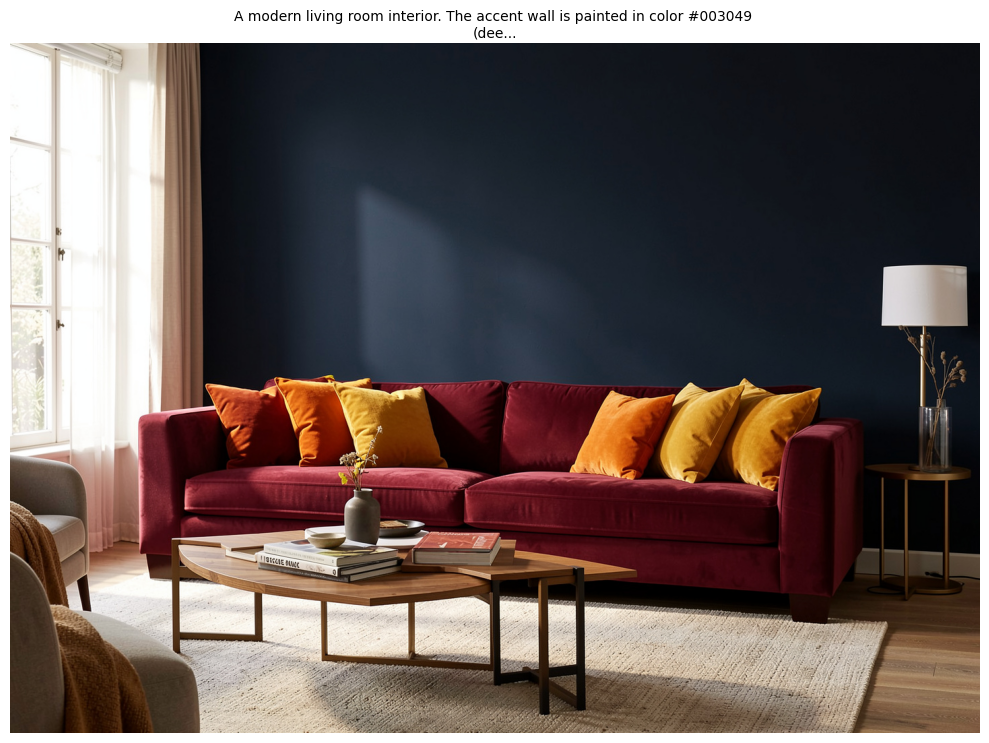

In [8]:
# Brand colors via hex codes
brand_prompt = """
A modern living room interior. The accent wall is painted in color #003049 
(deep navy). A plush velvet sofa in color #D62828 (rich crimson) sits against it. 
Throw pillows in color #F77F00 (vibrant orange) and color #FCBF49 (warm yellow) 
add contrast. Natural daylight creates a warm, inviting atmosphere. 
Interior design magazine style photography.
""".strip()

payload = {
    "prompt": brand_prompt,
    "width": 1440,
    "height": 1024,
    "seed": 123
}

color_image = generate_image("flux-2-klein-9b-private", payload)

---

# Part 2: Image Editing with Klein

**FLUX.2 Klein is the best open-source image editing model in the world.**

It excels at understanding context, preserving what matters, and making precise transformations. Whether you're swapping backgrounds, changing styles, or composing multiple references — Klein delivers.

### Key Principle
Reference images carry the visual details. Your prompt describes *what should change*, not what the image looks like.

### Edit Types
| Type | Description | Example Prompt |
|------|-------------|----------------|
| **Background swap** | Change the environment | "Place her in a coffee shop" |
| **Style transfer** | Apply a new visual style | "Turn into a watercolor painting" |
| **Object replacement** | Swap specific elements | "Replace the bike with a horse" |
| **Element addition** | Add new objects | "Add a cat sleeping on the chair" |
| **Attribute change** | Modify properties | "Change the dress from blue to red" |

---

# Part 2: Exploring Limitations

Klein 9B is excellent at general image generation, but like all foundation models, it has limitations:

1. **Specific identities** — It can't generate a specific person without training
2. **Custom characters** — Your brand mascot, game characters, etc.
3. **Niche styles** — Specific artistic styles not well-represented in training
4. **Specialized domains** — Technical diagrams, specific product designs

Let's see some examples where the model struggles.

Attempting to generate a specific character without training...
Submitting request to flux-2-klein-9b-private...
Request ID: ea8ee26c-2802-4c92-bb72-f31972fb9c3c
Cost: 0.0 credits
Waiting for result...


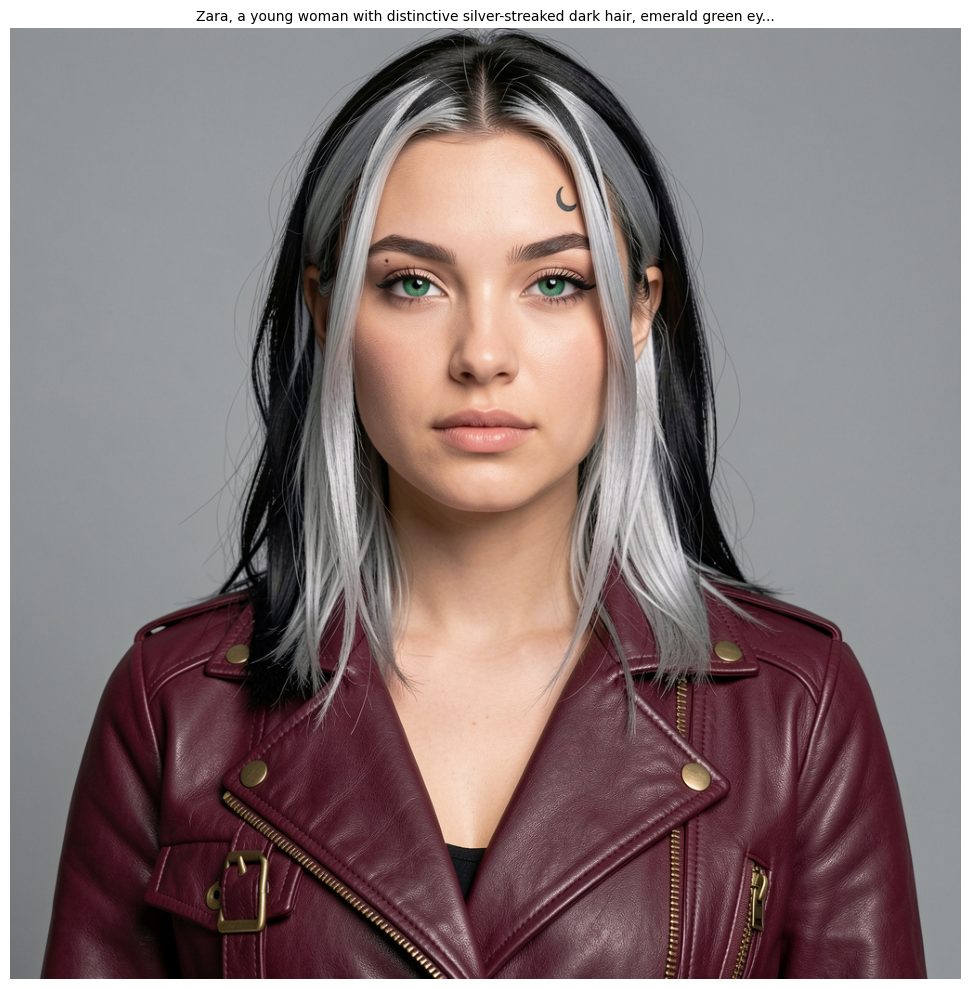


Note: The model generates a plausible interpretation, but can't maintain
consistency across multiple generations without fine-tuning.


In [9]:
# Example 1: Trying to generate a specific (fictional) character
# Without training, the model has no concept of "Zara" as a specific character

character_prompt = """
Zara, a young woman with distinctive silver-streaked dark hair, emerald green eyes, 
and a small crescent moon tattoo on her left temple. She wears her signature 
burgundy leather jacket with brass buckles. Portrait photography, studio lighting.
""".strip()

print("Attempting to generate a specific character without training...")
char_image = generate_image("flux-2-klein-9b-private", {"prompt": character_prompt, "width": 1024, "height": 1024, "seed": 42})

print("\nNote: The model generates a plausible interpretation, but can't maintain")
print("consistency across multiple generations without fine-tuning.")

Generating the same character prompt with different seeds...
Seed 42... Submitting request to flux-2-klein-9b-private...
Request ID: 5a4e9b8f-d973-43ab-8745-891f382b80c5
Cost: 0.0 credits
Waiting for result...
done
Seed 123... Submitting request to flux-2-klein-9b-private...
Request ID: 5158ed6e-c5bd-495c-a5f2-f40cf8b303a9
Cost: 0.0 credits
Waiting for result...
done
Seed 456... Submitting request to flux-2-klein-9b-private...
Request ID: d50838e5-6df0-4ecf-b112-cb25236b2bf9
Cost: 0.0 credits
Waiting for result...
done
Seed 789... Submitting request to flux-2-klein-9b-private...
Request ID: ba60b283-f381-4593-aec3-bec1d34b413d
Cost: 0.0 credits
Waiting for result...
done


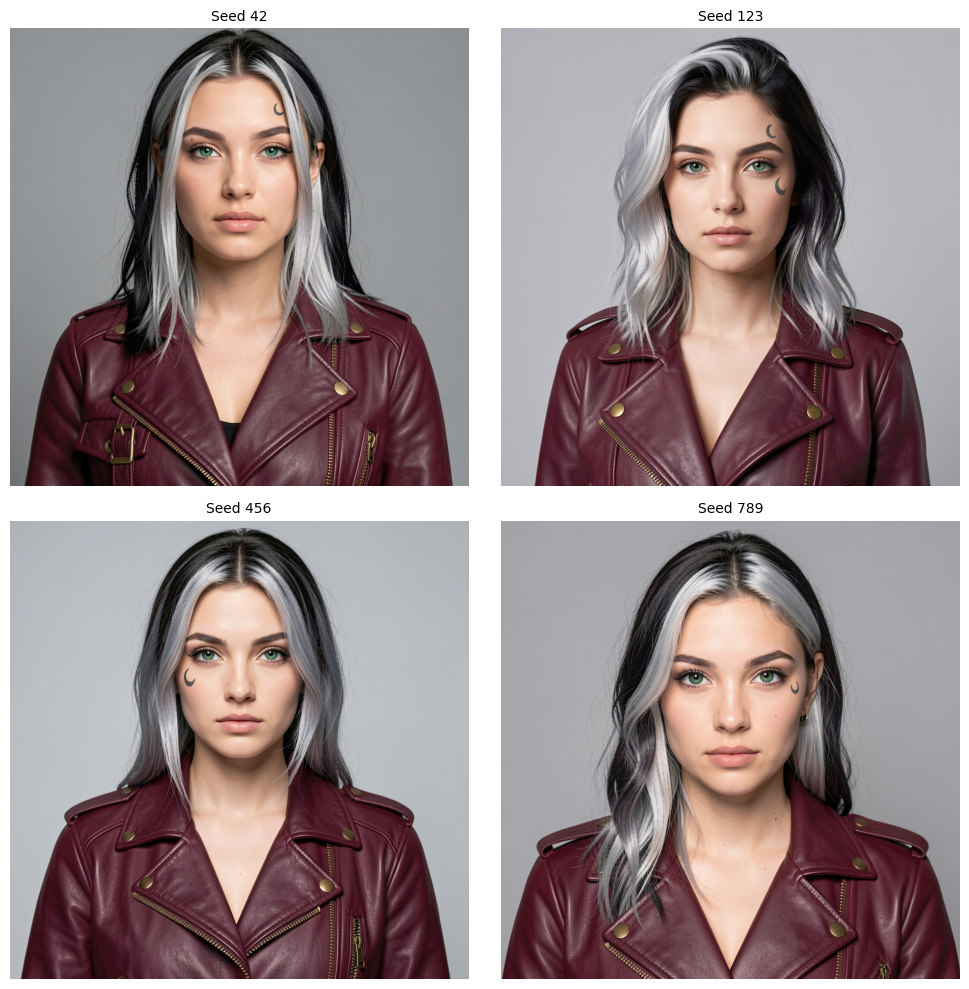


Problem: Each generation creates a different person.
The model doesn't have a consistent concept of 'Zara'.


In [11]:
# Generate the same "character" with different seeds
# This demonstrates inconsistency without training

print("Generating the same character prompt with different seeds...")
seeds = [42, 123, 456, 789]
char_images = []

for seed in seeds:
    print(f"Seed {seed}...", end=" ")
    img = generate_image("flux-2-klein-9b-private", 
                        {"prompt": character_prompt, "width": 1024, "height": 1024, "seed": seed}, 
                        show=False)
    char_images.append(img)
    print("done")

display_images_grid(char_images, [f"Seed {s}" for s in seeds], cols=2)

print("\nProblem: Each generation creates a different person.")
print("The model doesn't have a consistent concept of 'Zara'.")

Attempting to generate a specific artistic style...
Submitting request to flux-2-klein-9b-private...
Request ID: b3648c53-a21e-45a6-87ee-329f26cd593e
Cost: 0.0 credits
Waiting for result...


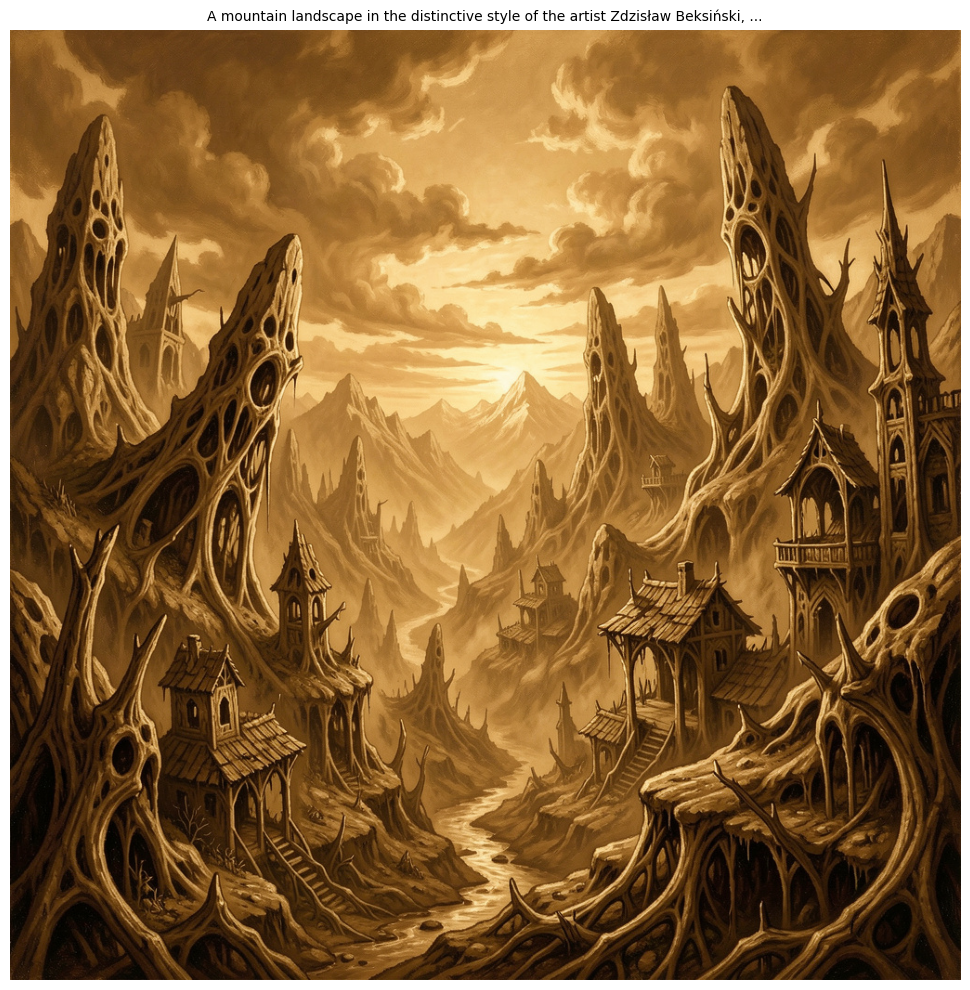


The model may capture some elements, but won't perfectly replicate
a specific artist's unique visual language.


In [12]:
# Example 2: Specific artistic style
# Trying to match a very specific, niche art style

style_prompt = """
A mountain landscape in the distinctive style of the artist Zdzisław Beksiński, 
with his characteristic blend of surrealism and gothic horror. Bone-like rock 
formations, decaying structures, amber and sepia tones, dreamlike atmosphere.
""".strip()

print("Attempting to generate a specific artistic style...")
style_image = generate_image("flux-2-klein-9b-private", {"prompt": style_prompt, "width": 1024, "height": 1024, "seed": 42})

print("\nThe model may capture some elements, but won't perfectly replicate")
print("a specific artist's unique visual language.")

In [ ]:
# Example 3: Brand-specific product
# The model doesn't know specific product designs

product_specific_prompt = """
The new BFL Model X smartwatch, featuring our signature hexagonal bezel design 
with the forest green dial and pine tree logo at 12 o'clock. Rose gold case 
with our patented quick-release leather strap system. Product photography 
on white background with soft shadows.
""".strip()

print("Attempting to generate a specific product design...")
brand_product = generate_image("flux-2-klein-9b", {"prompt": product_specific_prompt, "width": 1024, "height": 1024, "seed": 42})

print("\nThe model creates a generic smartwatch, not the specific design we described.")
print("For brand-specific products, you need to train the concept.")

## Summary: When You Need Fine-Tuning

| Use Case | Base Model | With LoRA |
|----------|------------|----------|
| Generic portraits | ✅ Excellent | — |
| Specific character (consistent) | ❌ Inconsistent | ✅ Consistent |
| General art styles | ✅ Good | — |
| Specific artist style | ⚠️ Approximate | ✅ Accurate |
| Generic products | ✅ Excellent | — |
| Your brand's products | ❌ Can't replicate | ✅ Accurate |

**This is where LoRA fine-tuning becomes essential.**

---

# Part 3: LoRA Fine-Tuning

**LoRA (Low-Rank Adaptation)** allows you to teach the model new concepts without retraining the entire model.

### Why LoRA?
- **Efficient** — Only trains a small adapter (~50-150MB)
- **Fast** — Training in minutes to hours, not days
- **Composable** — Stack multiple LoRAs
- **Preserves base model** — Easy to add/remove concepts

### What You Can Train
- **Characters** — Consistent faces, personas
- **Styles** — Artistic techniques, visual aesthetics
- **Objects** — Products, logos, specific items
- **Concepts** — Poses, compositions, moods

## 3.1 Preparing Training Data

Good training data is the key to successful LoRA training.

### Requirements
- **10-30 images** for most concepts (characters, styles)
- **High quality** — sharp, well-lit, consistent
- **Variety** — different angles, lighting, backgrounds
- **Captions** — descriptive text for each image

In [ ]:
# For this demo, we'll set up the structure for LoRA training
# In a real workshop, you'd provide actual training images

TRAINING_DIR = Path("./training_data")
TRAINING_DIR.mkdir(exist_ok=True)

# Directory structure for training
# training_data/
#   ├── images/
#   │   ├── 001.png
#   │   ├── 002.png
#   │   └── ...
#   └── captions/
#       ├── 001.txt
#       ├── 002.txt
#       └── ...

print("Training data structure:")
print(f"  {TRAINING_DIR}/")
print(f"    ├── images/     # Your training images")
print(f"    └── captions/   # Corresponding caption files")

In [ ]:
# Example: Creating caption files
# Each caption should describe the image AND include a trigger word

example_captions = [
    # For a character LoRA - use a unique trigger word like "ohwx"
    "A photo of ohwx woman with silver-streaked dark hair, emerald eyes, standing in a coffee shop, warm lighting",
    "ohwx woman portrait, looking at camera, burgundy leather jacket, outdoor setting, golden hour",
    "Full body shot of ohwx woman walking down a city street, casual outfit, overcast day",
    
    # For a style LoRA - describe the style consistently
    # "A landscape in the style of bfl_dark_surreal, bone-like formations, amber tones",
    # "Portrait in bfl_dark_surreal style, ethereal lighting, dreamlike atmosphere",
]

print("Example captions for character training:")
for i, caption in enumerate(example_captions, 1):
    print(f"\n{i}. {caption}")

print("\n" + "="*60)
print("Key: Use a unique trigger word (like 'ohwx') that doesn't exist")
print("in the model's vocabulary. This becomes your activation word.")

## 3.2 Training Configuration

Here's a typical configuration for training a character LoRA on Klein Base.

In [ ]:
# LoRA Training Configuration

training_config = {
    # Model
    "base_model": "black-forest-labs/FLUX.2-klein-9B-base",  # Use base (undistilled) for training
    
    # LoRA parameters
    "lora_rank": 16,           # Rank of the LoRA matrices (4-64, higher = more capacity)
    "lora_alpha": 16,          # Scaling factor (typically same as rank)
    "target_modules": [         # Which layers to train
        "to_q", "to_k", "to_v",  # Attention layers
        "to_out.0",
    ],
    
    # Training parameters
    "learning_rate": 1e-4,     # Learning rate
    "train_batch_size": 1,     # Batch size (limited by VRAM)
    "gradient_accumulation": 4, # Effective batch size = 4
    "max_train_steps": 1000,   # Total training steps
    "save_every": 250,         # Save checkpoint every N steps
    
    # Image processing
    "resolution": 1024,        # Training resolution
    "center_crop": True,
    "random_flip": True,       # Data augmentation
    
    # Memory optimization
    "mixed_precision": "bf16", # Use bfloat16 for training
    "gradient_checkpointing": True,
}

print("Training Configuration:")
print("="*50)
for key, value in training_config.items():
    print(f"{key:25} : {value}")

## 3.3 The Training Loop

Below is a simplified training script using `diffusers` + `peft`.

**Note**: This is a demonstration structure. For production training, use the BFL training scripts or established frameworks like `kohya_ss` or `SimpleTuner`.

In [ ]:
# Simplified LoRA training demonstration
# For actual training, use dedicated training scripts

import torch

def demonstrate_training_setup():
    """Show the key components of LoRA training."""
    
    print("LoRA Training Pipeline")
    print("="*50)
    
    print("\n1. Load the base model")
    print("   from diffusers import FluxPipeline")
    print("   pipe = FluxPipeline.from_pretrained('black-forest-labs/FLUX.2-klein-9B-base')")
    
    print("\n2. Add LoRA adapters")
    print("   from peft import LoraConfig, get_peft_model")
    print("   lora_config = LoraConfig(r=16, lora_alpha=16, target_modules=[...])")
    print("   pipe.unet = get_peft_model(pipe.unet, lora_config)")
    
    print("\n3. Training loop (simplified)")
    print("   for step, batch in enumerate(dataloader):")
    print("       latents = vae.encode(batch['images'])")
    print("       noise = torch.randn_like(latents)")
    print("       timesteps = sample_timesteps(batch_size)")
    print("       noisy_latents = scheduler.add_noise(latents, noise, timesteps)")
    print("       ")
    print("       # Get text embeddings")
    print("       text_embeds = text_encoder(batch['captions'])")
    print("       ")
    print("       # Predict noise")
    print("       noise_pred = unet(noisy_latents, timesteps, text_embeds)")
    print("       ")
    print("       # Compute loss and backprop")
    print("       loss = F.mse_loss(noise_pred, noise)")
    print("       loss.backward()")
    print("       optimizer.step()")
    
    print("\n4. Save the trained LoRA")
    print("   pipe.unet.save_pretrained('my_character_lora')")
    
    print("\n" + "="*50)
    print("Output: ~50-150MB LoRA adapter file")

demonstrate_training_setup()

In [ ]:
# Practical: Using a training script
# This is what you'd actually run

training_command = """
# Using diffusers training script
accelerate launch train_flux_lora.py \\
    --pretrained_model_name_or_path="black-forest-labs/FLUX.2-klein-9B-base" \\
    --train_data_dir="./training_data" \\
    --output_dir="./lora_output" \\
    --resolution=1024 \\
    --train_batch_size=1 \\
    --gradient_accumulation_steps=4 \\
    --learning_rate=1e-4 \\
    --lr_scheduler="cosine" \\
    --max_train_steps=1000 \\
    --lora_rank=16 \\
    --mixed_precision="bf16" \\
    --seed=42
"""

print("Example training command:")
print(training_command)
print("\nExpected training time on A100 (40GB): ~30-60 minutes for 1000 steps")
print("Expected training time on RTX 4090 (24GB): ~45-90 minutes for 1000 steps")

## 3.4 Monitoring Training

Key metrics to watch during training:

| Metric | Good Range | What It Means |
|--------|------------|---------------|
| **Loss** | Decreasing | Model is learning |
| **Learning rate** | 1e-5 to 1e-4 | Step size for updates |
| **VRAM usage** | <24GB | Fits on your GPU |

**Tips:**
- If loss plateaus early, increase learning rate
- If loss is unstable, decrease learning rate
- Generate samples every 250 steps to check quality
- Overfitting signs: model only generates training images exactly

---

# Part 4: Using Your Trained LoRA

After training, you have a small adapter file that can be loaded with the base model.

In [ ]:
# Loading and using a trained LoRA

def demonstrate_lora_loading():
    """Show how to load and use a trained LoRA."""
    
    print("Loading a Trained LoRA")
    print("="*50)
    
    print("\n# Load base model")
    print("from diffusers import FluxPipeline")
    print("")
    print("pipe = FluxPipeline.from_pretrained(")
    print("    'black-forest-labs/FLUX.2-klein-9B-base',")
    print("    torch_dtype=torch.bfloat16")
)
    print(")")
    print("pipe.to('cuda')")
    print("")
    print("# Load LoRA weights")
    print("pipe.load_lora_weights('./lora_output/pytorch_lora_weights.safetensors')")
    print("")
    print("# Generate with trigger word")
    print("prompt = 'A photo of ohwx woman reading a book in a library, warm lighting'")
    print("image = pipe(prompt, num_inference_steps=28).images[0]")
    
    print("\n" + "="*50)
    print("Now 'ohwx' activates your trained character!")

demonstrate_lora_loading()

In [ ]:
# LoRA weight scaling
# You can adjust how strongly the LoRA affects generation

print("LoRA Weight Scaling")
print("="*50)
print("")
print("# Default: full strength (1.0)")
print("pipe.load_lora_weights(lora_path)")
print("")
print("# Reduced strength for subtler effect")
print("pipe.load_lora_weights(lora_path, adapter_weights=[0.7])")
print("")
print("# Higher strength for stronger effect")
print("pipe.load_lora_weights(lora_path, adapter_weights=[1.2])")
print("")
print("Typical values:")
print("  0.5 - 0.7  : Subtle influence")
print("  0.8 - 1.0  : Standard usage")
print("  1.0 - 1.5  : Strong effect (may reduce diversity)")

In [ ]:
# Combining multiple LoRAs

print("Combining Multiple LoRAs")
print("="*50)
print("")
print("# Load character LoRA")
print("pipe.load_lora_weights('character_lora', adapter_name='character')")
print("")
print("# Load style LoRA")
print("pipe.load_lora_weights('style_lora', adapter_name='style')")
print("")
print("# Set weights for each")
print("pipe.set_adapters(['character', 'style'], adapter_weights=[1.0, 0.8])")
print("")
print("# Generate with both")
print("prompt = 'ohwx woman portrait in bfl_dark_surreal style'")
print("image = pipe(prompt).images[0]")
print("")
print("Result: Your character rendered in your custom style!")

## 4.2 Before vs After: The Power of LoRA

Let's visualize what becomes possible with fine-tuning.

*In the workshop, this would show actual results from a pre-trained LoRA.*

In [ ]:
# Comparison: Base model vs LoRA-enhanced

comparison_scenarios = [
    {
        "name": "Character Consistency",
        "base_result": "Different person each time",
        "lora_result": "Same character, any pose/setting",
    },
    {
        "name": "Brand Products",
        "base_result": "Generic product design",
        "lora_result": "Exact product with brand details",
    },
    {
        "name": "Artistic Style",
        "base_result": "Approximate style interpretation",
        "lora_result": "Authentic style replication",
    },
    {
        "name": "Game Assets",
        "base_result": "Generic game-like assets",
        "lora_result": "Your game's specific aesthetic",
    },
]

print("What LoRA Fine-Tuning Enables")
print("="*60)
print(f"{'Use Case':<25} {'Base Model':<20} {'With LoRA':<20}")
print("-"*60)
for scenario in comparison_scenarios:
    print(f"{scenario['name']:<25} {scenario['base_result']:<20} {scenario['lora_result']:<20}")
print("="*60)

---

# Summary

## Key Takeaways

### FLUX.2 Klein
- **Klein 9B** — Best quality in the Klein family, sub-second API inference
- **Klein 4B** — Apache 2.0 license, smallest footprint
- **Base models** — Undistilled variants for fine-tuning

### When to Use LoRA
- **Consistent characters** — Faces, personas, avatars
- **Brand assets** — Products, logos, visual identity
- **Custom styles** — Artistic techniques, aesthetics
- **Domain adaptation** — Specialized content types

### Training Tips
- **10-30 images** is often enough
- **Use a unique trigger word** (like `ohwx`)
- **Quality > quantity** for training data
- **Start with rank 16**, adjust if needed
- **Generate samples** during training to monitor

---

## Resources

### API & Documentation
- **Docs**: [docs.bfl.ai](https://docs.bfl.ai)
- **API Dashboard**: [dashboard.bfl.ai](https://dashboard.bfl.ai)
- **Playground**: [playground.bfl.ai](https://playground.bfl.ai)

### Models & Training
- **Hugging Face**: [huggingface.co/black-forest-labs](https://huggingface.co/black-forest-labs)
- **Klein 9B Base**: `black-forest-labs/FLUX.2-klein-9B-base`
- **Klein 4B Base**: `black-forest-labs/FLUX.2-klein-4B-base`

### Community
- **Discord**: [discord.gg/blackforestlabs](https://discord.gg/blackforestlabs)
- **GitHub**: [github.com/black-forest-labs](https://github.com/black-forest-labs)

---

*Workshop by Black Forest Labs x NVIDIA*

In [ ]:
# Cleanup (optional)
# import torch
# if 'pipe' in dir():
#     del pipe
#     torch.cuda.empty_cache()
#     print(f"VRAM freed. Current usage: {torch.cuda.memory_allocated() / 1e9:.1f} GB")